# Linear Model Predictive Control

Consider a linear time-invariant system given by:

$$ x_{k+1} = A x_k + B u_k, $$

where $x_k \in \mathbb{R}^n$ is the state, $u_k \in \mathbb{R}^m$ is the control input, and $A \in \mathbb{R}^{n \times n}$ and $B \in \mathbb{R}^{n \times m}$ are constant matrices. The goal of linear MPC, given a reference trajectory $x_{ref,k}$ and $u_{ref,k}$, is to find a sequence of control inputs $u_k$ that will drive the system to the reference trajectory. 

Given a horizon of $N$ steps, at every time $t_i$ when the state (or its estimate) is $x_i$, the linear MPC problem can be formulated as:

\begin{align}
\text{minimize}_{u_{i+k}} \quad & (x_{i+N} - x_{ref,{i+N}})^T Q_N (x_{i+k} - x_{ref,{i+N}}) + \sum_{k=0}^{N-1} (x_{i+k} - x_{ref,{i+k}})^T Q (x_{i+k} - x_{ref,{i+k}}) + \sum_{k=0}^{N-1} (u_{i+k} - u_{ref,{i+k}}) R (u_{i+k} - u_{ref,{i+k}}) \\
\text {subject to} \quad & x_{i+k+1} = A x_{i+k} + B u_{i+k}, \quad k = 0, \cdots, N-1 \\
\quad & x_{i} = x_{i}^{0}, \\
\quad & x_{lb}<x_{i+k} < x_{ub}, \\
\quad & u_{lb}<u_{i+k} < u_{ub},
\end{align}

where $Q_N \in \mathbb{R}^{n \times n}$, $Q \in \mathbb{R}^{n \times n}$, and $R \in \mathbb{R}^{m \times m}$ are positive definite weighting matrices, $(\cdot)_{lb}$ and $(\cdot)_{ub}$ are lower and upper bounds. The first equality constraint is the system dynamics, the second equality constraint is the initial condition, and the last two inequalities are the state and control input constraints, representing admissible values for the state and control input, respectively. The objective function to be minimized is quadratic. The first term represents the terminal cost for deviations of the terminal state from reference terminal state. Similarly, the second and third terms represent the stage cost for deviations of the state and control input from their respective references.

While the solution for $u_{i+k}$ is obtained for $k=[0,1,2,\cdots, N-1]$, only the first control input $u_i$ is applied to the system. The optimization problem is then solved again at the next time step, and the first control input of the new solution is applied to the system. This process is repeated at every time step as the plant's state evolves in time.

For **nonlinear systems** to be controlled by linear MPC, there are two approaches. First, the system may be linearized around an equilibrium point to obtain a linear time-invariant system. Second, the nonlinear system bay be linearized around the time-varying reference trajectory. Presently, only the first approach is implemented in Collimator. Other limitations of the `LinearDiscreteTime` block in Collimator are:

1. $Q_N$ = $Q$ is assumed.
2. bounds on $x$ are not implemented.
3. $u_{lb}$ and $u_{ub}$ are assumed to be the same for all the $m$ components of the control vector.
4. $x_{ref}$ is assumed to be a constant (so the block is presently only suitable for regulation of state as opposed to tracking)

The block expects an `LTISystem` continous plant, and internally converts the plant into a discrete-time representation with Euler discretization.

##  Control of a Cessna Citation aircraft

<img src="../media/cessna.png" alt="cessna" style="width: 800px;"/>

A continuous-time linearized model of a Cessna aircraft at a speed of 128.2 m/s and an altitude of 5,000m is given by the following [1,2]:

\begin{align}
\dot{x} = \begin{bmatrix}
-1.2822 & 0 & 0.98 & 0 \\
0 & 0 & 1 & 0 \\
-5.4293 & 0 & -1.8366 & 0 \\
-128.2 & 128.2 & 0 & 0
\end{bmatrix}x + \begin{bmatrix}
-0.3 \\
0 \\
- 17 \\
0 \end{bmatrix}u \\
\end{align}

The components of the state vector $x$ are:

$x_1$: the angle of attack (specified in radians): This is the angle between the airplane's longitudinal axis and the aircraft's velocity vector. 


$x_2$: the pitch angle (specified in radians). This is the angle between the airplane's longitudinal axis and the horizontal plane.

$x_3$: the pitch rate, representing the rate of change of the pitch angle $x_2$ (specified in radians/sec). 

$x_4$: the aircrafts's altitude (specified in meters) relative to the reference altitude of 5,000 m, at which the linearized model is available.

The control variable $u$ is the angle (specified in radians) of the elevator, a controllable surface on the aircraft's tail. The elevator can be changed to control the aircraft's pitch.

Our goal with MPC is to design a controller that regulates the linearized system's altitude to zero (i.e., the aircraft's altitude to 5,000m), subject to the constraint of the control input magnitude not exceeding 0.262 radians.

**References**:
> [1] F. Borrelli∗, C. Jones†, M. Morari, Model Predictive Control Part III – Feasibility and Stability, Course notes.
  [Available online.](https://ceid.utsa.edu/ataha/wp-content/uploads/sites/38/2017/10/MPC_Intro.pdf)
>
> [2] L. Lessard, Model Predictive Control, Course notes. [Available online](https://laurentlessard.com/teaching/me7247/lectures/lecture%2020%20-%20model%20predictive%20control.pdf)


### Cessna model and MPC configuration parameters

Let's first create the matrices for the linearized Cessna model and specify the MPC parameters. We implement the LTI system with full observation so that its output can be used by the MPC.

In [1]:
import control
import jax.numpy as jnp
import collimator

from collimator.library import LinearDiscreteTimeMPC, LTISystem, linearize

from collimator.simulation import SimulatorOptions

import matplotlib.pyplot as plt

In [2]:
# Cessna continuous model

nx = 4
ny = nx  # Full state observation (avoids building an estimator for now)
nu = 1

A = jnp.array(
    [
        [-1.2822, 0.0, 0.98, 0.0],
        [0.0, 0.0, 1.0, 0.0],
        [-5.4293, 0.0, -1.8366, 0.0],
        [-128.2, 128.2, 0.0, 0.0],
    ]
)

B = jnp.array([-0.3, 0.0, -17.0, 0.0]).reshape((nx, nu))

# Full state observation
C = jnp.eye(ny)
D = jnp.zeros((ny, nu))

In [3]:
# MPC config

N = 10  # number of steps in the horizon
dt = 0.25  # duration of each step within the horizon
Q = jnp.eye(nx)  # penalty matrix for the state vector
R = jnp.array([100.0])  # penalty matrix for control vector

x_ref = jnp.array([0.0, 0.0, 0.0, 0.0])  # Reference trajectory for regualtion

lbu = -0.262  # lower bound on the control variable
ubu = 0.262  # upper bound on the control variable

### Unconstrained

Let's first observe the MPC controller when the constraint on $u$ is not specified.

In [4]:
x0 = jnp.array([0.0, 0.0, 0.0, 100.0])  # aircraft's initial state vector

builder = collimator.DiagramBuilder()

# create an LTISystem (continous) with the system matrices
plant = LTISystem(A, B, C, D, initialize_states=x0, name="cessna")

# create an MPC controller: we pass the continuous LTI system and the
# MPC block will internally user Euler discretization with specified dt
# omitting the lbu and ubu arguments eliminates the constraints
# from the MPC optimization problem
mpc = LinearDiscreteTimeMPC(plant, Q, R, N, dt, x_ref, name="controller")

# add the systems to diagram builder
builder.add(plant)
builder.add(mpc)

# connect plant output to MPC vice versa
builder.connect(plant.output_ports[0], mpc.input_ports[0])
builder.connect(mpc.output_ports[0], plant.input_ports[0])


# build and simulate
diagram = builder.build()
context = diagram.create_context()

recorded_signals = {"x": plant.output_ports[0], "u": mpc.output_ports[0]}

options = SimulatorOptions(max_minor_step_size=0.25)

sol = collimator.simulate(
    diagram, context, (0.0, 10.0), options=options, recorded_signals=recorded_signals
)

Initialized callback cessna:u_0 with prereqs []
Initialized callback cessna:cessna_ode with prereqs [1, 2, 8]
Initialized callback cessna:y_0 with prereqs [0]
Initialized callback controller:u_0 with prereqs []
Initialized callback controller:y_0 with prereqs [8]


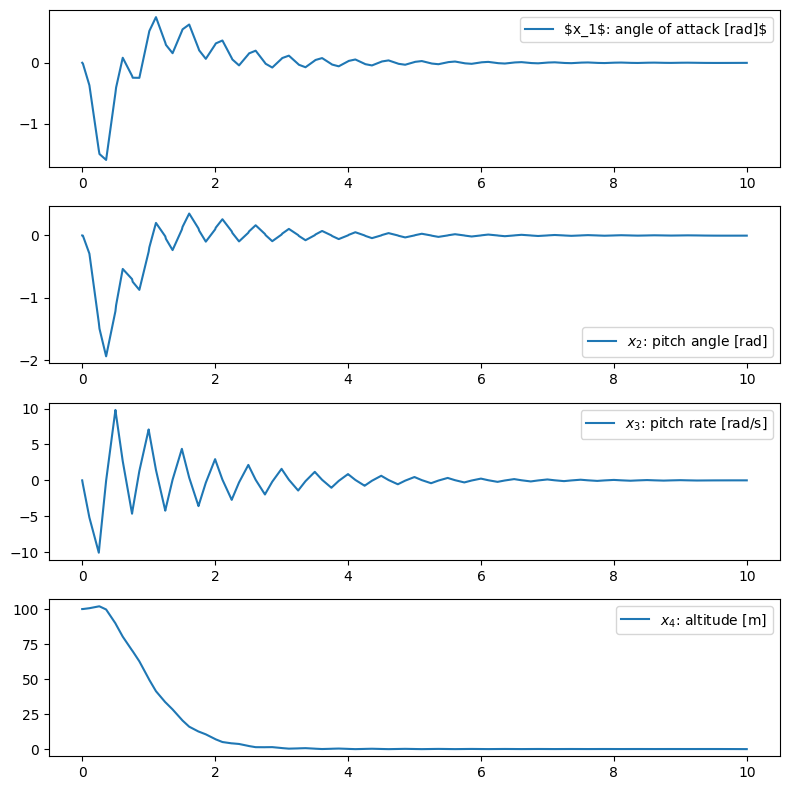

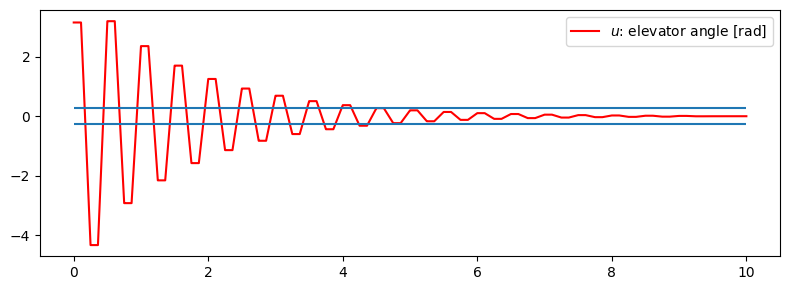

In [5]:
state_labels = [
    "$x_1$: angle of attack [rad]$",
    "$x_2$: pitch angle [rad]",
    "$x_3$: pitch rate [rad/s]",
    "$x_4$: altitude [m]",
]
fig, axs = plt.subplots(4, 1, figsize=(8, 8))
for idx, ax in enumerate(axs):
    ax.plot(sol.time, sol.outputs["x"][:, idx], label=state_labels[idx])
    ax.legend()
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(sol.time, sol.outputs["u"], "r-", label="$u$: elevator angle [rad]")
ax.hlines([lbu, ubu], sol.time[0], sol.time[-1])
ax.legend()
fig.tight_layout()

While the aircraft's altitute is regulated to zero, we see that the the magnitudes of the applied control input are too large. This is natural as we did not specify any constraints to the MPC. Let's specify them now.

### Adding constraint on the control

We follow the same procedure as above, except when creating the MPC block, we additionally pass the `lbu` and `ubu` arguments.

In [6]:
builder = collimator.DiagramBuilder()

plant = LTISystem(A, B, C, D, initialize_states=x0, name="cessna")
mpc = LinearDiscreteTimeMPC(
    plant, Q, R, N, dt, x_ref, lbu=lbu, ubu=ubu, name="controller"
)

builder.add(plant)
builder.add(mpc)

builder.connect(plant.output_ports[0], mpc.input_ports[0])
builder.connect(mpc.output_ports[0], plant.input_ports[0])

diagram = builder.build()
context = diagram.create_context()

recorded_signals = {"x": plant.output_ports[0], "u": mpc.output_ports[0]}

options = SimulatorOptions(max_minor_step_size=0.05)

sol = collimator.simulate(
    diagram, context, (0.0, 10.0), options=options, recorded_signals=recorded_signals
)

Initialized callback cessna:u_0 with prereqs []
Initialized callback cessna:cessna_ode with prereqs [1, 2, 8]
Initialized callback cessna:y_0 with prereqs [0]
Initialized callback controller:u_0 with prereqs []
Initialized callback controller:y_0 with prereqs [8]


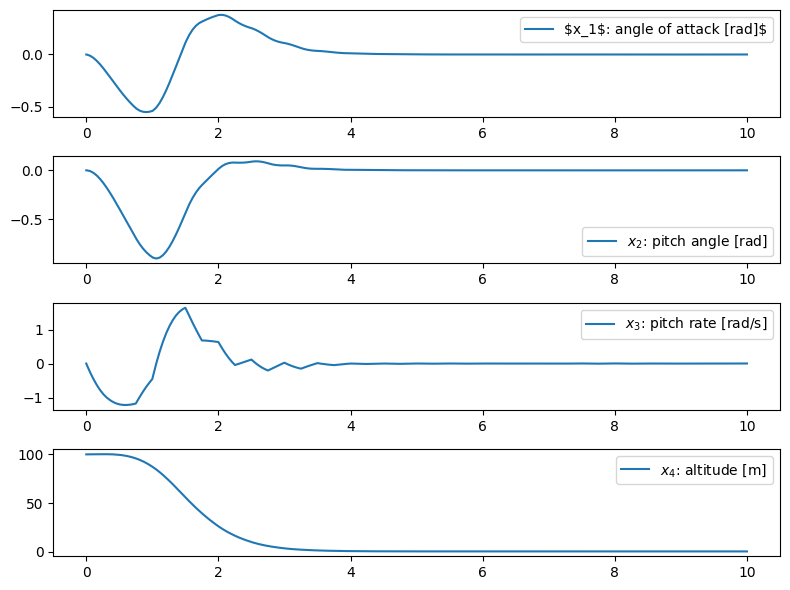

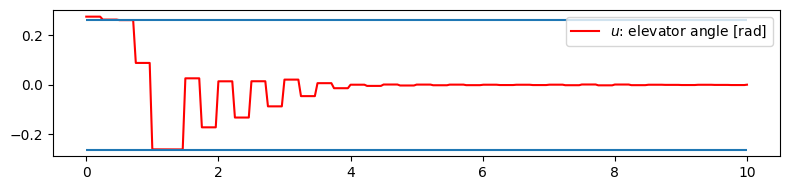

In [10]:
state_labels = [
    "$x_1$: angle of attack [rad]$",
    "$x_2$: pitch angle [rad]",
    "$x_3$: pitch rate [rad/s]",
    "$x_4$: altitude [m]",
]
fig, axs = plt.subplots(4, 1, figsize=(8, 6))
for idx, ax in enumerate(axs):
    ax.plot(sol.time, sol.outputs["x"][:, idx], label=state_labels[idx])
    ax.legend()
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(sol.time, sol.outputs["u"], "r-", label="$u$: elevator angle [rad]")
ax.hlines([lbu, ubu], sol.time[0], sol.time[-1])
ax.legend()
fig.tight_layout()

The contrainsts are well respected now. The minor violations in the initial two steps can potentially be eliminated by tighter tolerances.

## Pendulum

Here, we demonsrate how a linearized version of a nonlinear plant can be used in MPC. 

<img src="../media/pendulum.png" alt="pendulum" style="width: 300px;"/>

We use a damped pendulum model, with the following dynamics:

\begin{equation}
\dot{x} = 
\begin{bmatrix}
\dot{\theta} \\ \dot{\omega}
\end{bmatrix} = 
\begin{bmatrix}
\omega \\ -\dfrac{g}{L} \sin(\theta) - \dfrac{b}{m L^2} \omega +  \dfrac{u}{m L^2}
\end{bmatrix}.
\end{equation}

The state vector is $x = [\theta, \omega]^T$ and the control input is the torque $u$. The pendulum parameters are mass $m$, length $L$, damping coefficients $b$, and acceleration due to gravity $g$.

In [11]:
from collimator.models import Pendulum

### Linearise the plant at the vertically-down equilibrium point

In [12]:
x_eq = jnp.array([0.0, 0.0])
u_eq = jnp.array([0.0])

pendulum = Pendulum(input_port=True, full_state_output=True)
# Fix the input_port to u_eq
with pendulum.input_ports[0].fixed(u_eq):
    # Create a base context
    base_context = pendulum.create_context()
    # Set the the continuous state to x_eq in the context
    eq_context = base_context.with_continuous_state(x_eq)
    # Call linearize for the pendulum plant and equilibrium context
    linear_pendulum = linearize(pendulum, eq_context)

A, B = linear_pendulum.A, linear_pendulum.B

Initialized callback Pendulum_7_:Pendulum_7__ode with prereqs [1, 2, 8]
Initialized callback Pendulum_7_:u with prereqs []
Initialized callback Pendulum_7_:x with prereqs [2]
Initialized callback LTISystem_8_:u_0 with prereqs []
Initialized callback LTISystem_8_:LTISystem_8__ode with prereqs [1, 2, 8]
Initialized callback LTISystem_8_:y_0 with prereqs [0]


### MPC config

In [13]:
x0 = jnp.array([1.0, 0.0])  # initial condition for the pendulum

Q = jnp.eye(2)
R = 0.1 * jnp.eye(1)
dt = 0.1
x_ref = x_eq

lbu = -5.0
ubu = 5.0

### Build diagram and simulate

In [14]:
builder = collimator.DiagramBuilder()

plant = Pendulum(x0=x0, input_port=True, full_state_output=True)
mpc = LinearDiscreteTimeMPC(
    linear_pendulum, Q, R, N, dt, x_ref, lbu=lbu, ubu=ubu, name="controller"
)

builder.add(plant)
builder.add(mpc)

builder.connect(plant.output_ports[0], mpc.input_ports[0])
builder.connect(mpc.output_ports[0], plant.input_ports[0])

diagram = builder.build()
context = diagram.create_context()

recorded_signals = {"x": plant.output_ports[0], "u": mpc.output_ports[0]}

options = SimulatorOptions(max_minor_step_size=0.1)

sol = collimator.simulate(
    diagram, context, (0.0, 5.0), options=options, recorded_signals=recorded_signals
)

Initialized callback Pendulum_9_:Pendulum_9__ode with prereqs [1, 2, 8]
Initialized callback Pendulum_9_:u with prereqs []
Initialized callback Pendulum_9_:x with prereqs [2]
Initialized callback controller:u_0 with prereqs []
Initialized callback controller:y_0 with prereqs [8]


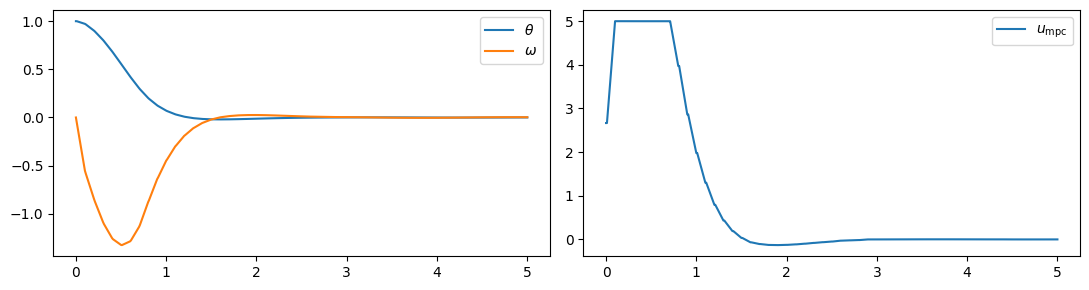

In [15]:
t = sol.time
x = sol.outputs["x"]
u = sol.outputs["u"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))
ax1.plot(t, x[:, 0], label=r"$\theta$")
ax1.plot(t, x[:, 1], label=r"$\omega$")
ax2.plot(t, u, label=r"$u_\mathrm{mpc}$")
ax1.legend()
ax2.legend()
fig.tight_layout()
plt.show()

We observe that the pendulum is driven to the zero vector state, while not violating the constraint that torque magnitude should not exceed 5 N.m